# Mask R-CNN - Inspect Nucleus Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import nucleus

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Comment out to reload imported modules if they change
%load_ext autoreload
%autoreload 2

## Configurations

In [3]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/nucleus")

# Inference Configuration
config = nucleus.NucleusInferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                2.0
IMAGE_RESIZE_MODE              pad64
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'rpn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES  

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# Only inference mode is supported right now
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    fig, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    fig.tight_layout()
    return ax

## Load Validation Dataset

In [6]:
print(DATASET_DIR)

/medical_data/zhuoyao_workspace/mask-rcnn/orginal/Mask_RCNN/datasets/nucleus


In [8]:
# Load validation dataset
dataset = nucleus.NucleusDataset()
#dataset.load_nucleus(DATASET_DIR, "val")
dataset.load_nucleus(DATASET_DIR, 'test')
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 39
Classes: ['BG', 'nucleus']


[autoreload of nucleus failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 384, in superreload
    update_generic(old_obj, new_obj)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 323, in update_generic
    update(a, b)
  File "/usr/local/lib/python3.5/dist-packages/IPython/extensions/autoreload.py", line 278, in update_class
    if old_obj == new_obj:
ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
]


## Load Model

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference",
                              model_dir=LOGS_DIR,
                              config=config)

In [10]:
# Path to a specific weights file
#weights_path = "/medical_data/zhuoyao_workspace/final_medical_cervix_2/src/SEGMENT/Mask_RCNN/samples/nucleus/weights.h5"
weights_path = '/medical_data/zhuoyao_workspace/mask-rcnn/orginal/Mask_RCNN/logs/nucleus20180921T1318/mask_rcnn_nucleus_0038.h5'
# Or, load the last model you trained
#weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /medical_data/zhuoyao_workspace/mask-rcnn/orginal/Mask_RCNN/logs/nucleus20180921T1318/mask_rcnn_nucleus_0038.h5
Re-starting from epoch 38


## Run Detection

image ID: nucleus.New_N_IMG001x008 (2) New_N_IMG001x008
Original image shape:  [1216 1936    3]
Processing 1 images
image                    shape: (2432, 3904, 3)       min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 2432, 3904, 3)    min:    0.00000  max:  244.00000  uint8
image_metas              shape: (1, 14)               min:    0.00000  max: 3904.00000  float64
anchors                  shape: (1, 2371314, 4)       min:   -0.03723  max:    1.01090  float32


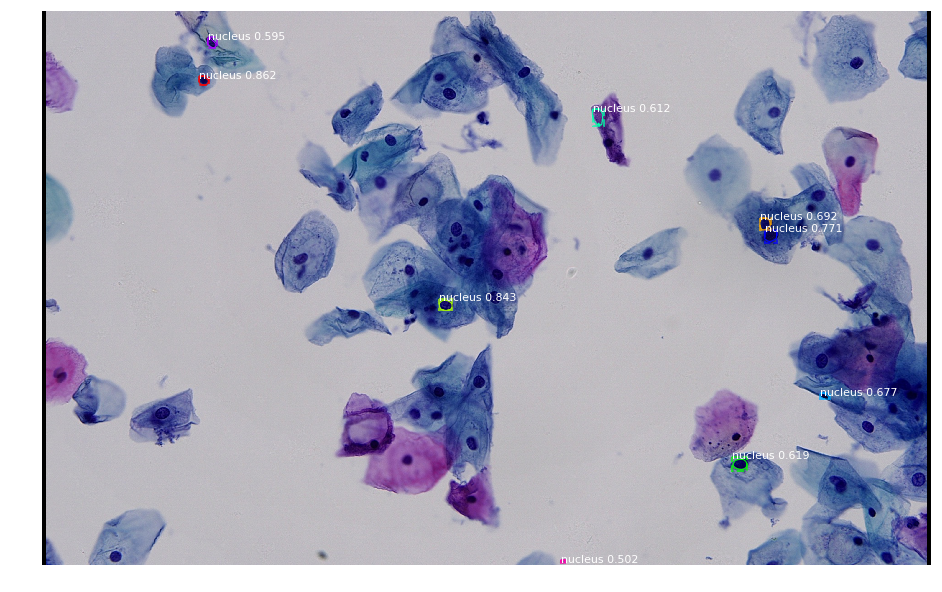

CPU times: user 7.59 s, sys: 2.26 s, total: 9.85 s
Wall time: 9 s


In [12]:
%%time

image_id = random.choice(dataset.image_ids)
#for validation
#image, image_meta, gt_class_id, gt_bbox, gt_mask =\
#    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

#for test 
image, image_meta = modellib.load_image(dataset, config, image_id)

info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

# Run object detection
results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)

# Display results
r = results[0]
#log("gt_class_id", gt_class_id)
#log("gt_bbox", gt_bbox)
#log("gt_mask", gt_mask)

# Compute AP over range 0.5 to 0.95 and print it
#utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
#                       r['rois'], r['class_ids'], r['scores'], r['masks'],
#                       verbose=1)
'''
visualize.display_differences(
    image,
    gt_bbox, gt_class_id, gt_mask,
    r['rois'], r['class_ids'], r['scores'], r['masks'],
    dataset.class_names, ax=get_ax(),
    show_box=False, show_mask=False,
    iou_threshold=0.5, score_threshold=0.5)'''

visualize.display_instances(
    image,
    r['rois'],r['masks'],r['class_ids'],dataset.class_names,scores=r['scores'], show_mask=False
    )

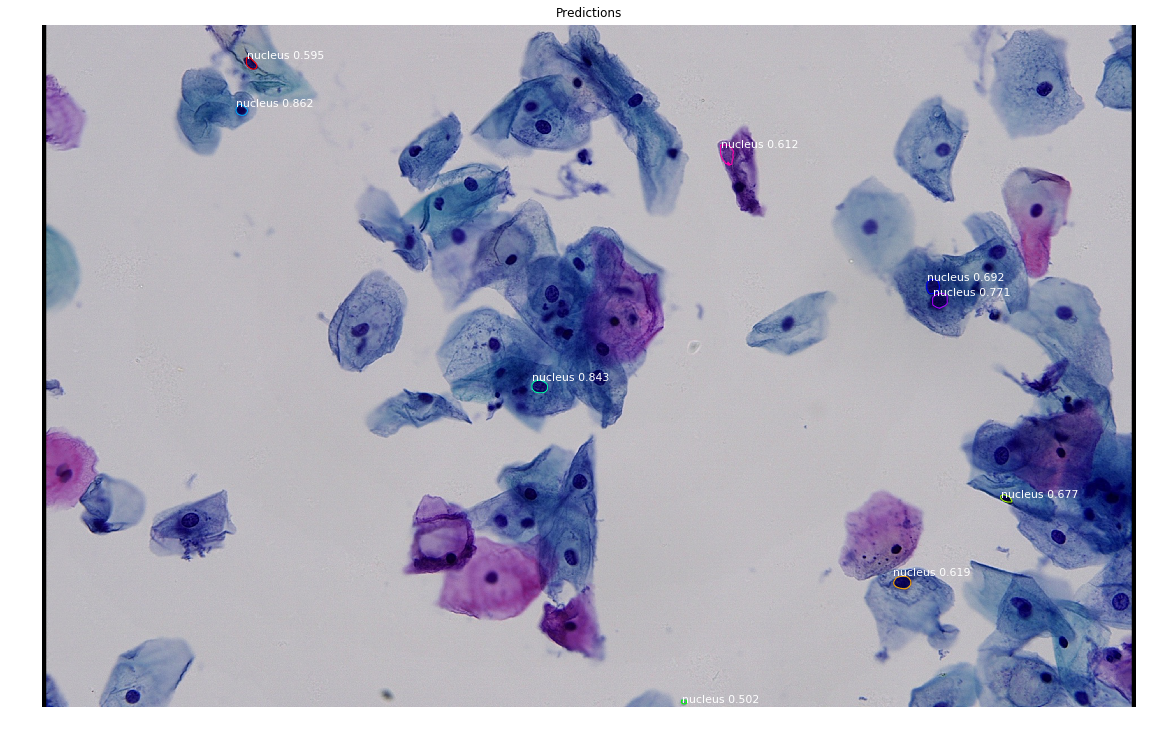

In [13]:
# Display predictions only
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax(1),
                            show_bbox=False, show_mask=False,
                            title="Predictions")

## Predict all test pap smears

we will see the total time cost of all 38 images

In [ ]:
%%time

r = dict()

for image_id in dataset.image_ids:
    image, image_meta = modellib.load_image(dataset, config, image_id)

    info = dataset.image_info[image_id]
    print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
    print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])

    # Run object detection
    start = time.time()
    results = model.detect_molded(np.expand_dims(image, 0), np.expand_dims(image_meta, 0), verbose=1)
    end = time.time()
    print("Predict time: {} s".format((end-start)))
    
    # Display results
    r[image_id] = results[0]

In [ ]:
visual_id = random.choice(dataset.image_ids)

image, _ = modellib.load_image(dataset, config, visual_id)
result = r[visual_id]

info = dataset.image_info[visual_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], visual_id, 
                                       dataset.image_reference(visual_id)))
#print("Original image shape: ", modellib.parse_image_meta(image_meta[np.newaxis,...])["original_image_shape"][0])


visualize.display_instances(
    image,
    result['rois'],result['masks'],result['class_ids'],dataset.class_names,scores=result['scores'], show_mask=False
    )